In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from rw import scan_handler

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

%load_ext autoreload
%autoreload 2

In [20]:
file_path = "/home/cmsdaq/Analysis/Data/reco/run0316.scan"    # series config, read S11 and S21
reader = scan_handler.ScanReader(file_path)        # create the object

In [21]:
d = reader.get_parameters('depth')
locs = np.where((d!=-2) & (d>0.1))[0]

print(d)
print(locs)

[0.57192176]
[0]


0


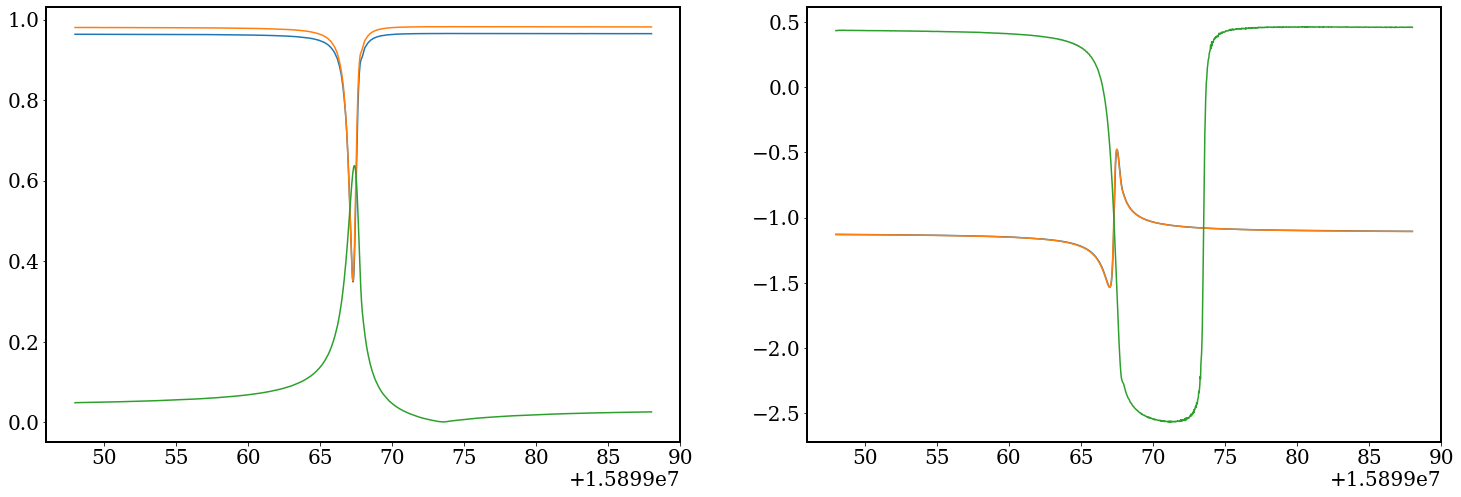

In [22]:

for loc in locs:
    print(loc)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(25)


    power = reader.get_resonance(loc=loc,label='S11')['power']
    power = 10**(power/20)
    phase = reader.get_resonance(loc=loc,label='S11')['phase']
    freq = reader.get_resonance(loc=loc,label='S11')['freq']
    ax1.plot(freq, power)
    ax2.plot(freq, phase)

    power = reader.get_resonance(loc=loc,label='S22')['power']
    power = 10**(power/20)
    phase = reader.get_resonance(loc=loc,label='S22')['phase']
    freq = reader.get_resonance(loc=loc,label='S22')['freq']
    ax1.plot(freq, power)
    ax2.plot(freq, phase)

    power = reader.get_resonance(loc=loc,label='S21')['power']
    power = 10**(power/20)
    phase = reader.get_resonance(loc=loc,label='S21')['phase']
    freq = reader.get_resonance(loc=loc,label='S21')['freq']
    ax1.plot(freq, power)
    ax2.plot(freq, phase)

    plt.show()

0
conversion is: dB-lin
[ 2.79100411e-06  1.25000001e-07  9.34710543e+00 -1.83080812e+03
  1.71128381e+04  1.00000000e+00] 
 [[ 0.00000000e+00  3.40750000e-08  9.34708822e+00 -1.83080812e+04
   1.71128381e+03  0.00000000e+00]
 [ 2.79100411e-04  3.40750000e-03  9.34712230e+00 -1.83080812e+02
   1.71128381e+05  1.00000000e+02]]
Parametro  1 :  1.7656204982192186e-06  +/-  1.0782167170844812e-08
Parametro  2 :  9.479852754293442e-07  +/-  6.39428206771227e-09
Parametro  3 :  9.347105426626772  +/-  8.045659712598644e-09
Parametro  4 :  -1829.688087309349  +/-  39.76338846270789
Parametro  5 :  17102.31753116716  +/-  371.6725844363978
Parametro  6 :  1.4257124545807625  +/-  0.02505456206446165
Q = 4.93e+06  +/-  0.00424355732158117


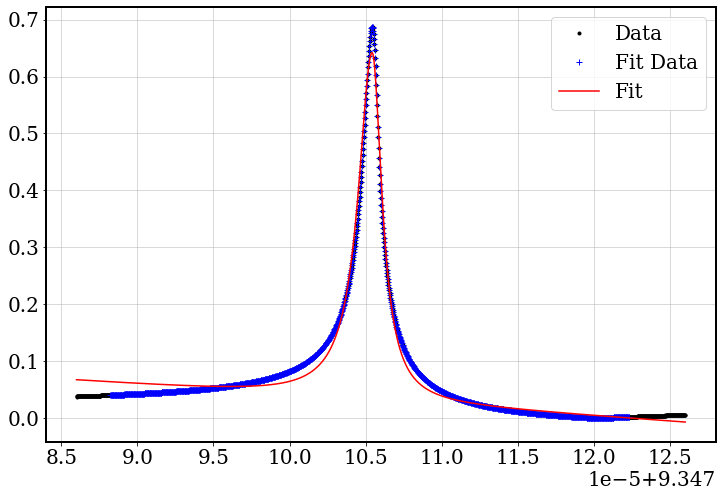

In [24]:
from process import utils


for loc in locs:
    print(loc)
    power = reader.get_resonance(loc=loc,label='S21')['power']
    phase = reader.get_resonance(loc=loc,label='S21')['phase']
    freq = reader.get_resonance(loc=loc,label='S21')['freq']

    utils.fit_resonance(freq*1e-6, power,verbose=True)
    #plt.plot(freq,power)
    #plt.plot(freq,phase)
    #power = reader.get_resonance(loc=l,label='S11')['power']
    #freq = reader.get_resonance(loc=l,label='S11')['freq']
    #phase = reader.get_resonance(loc=l,label='S11')['phase']
    #plt.plot(freq,power)
    #plt.plot(freq,phase)
    
    #plt.legend()
    #plt.xlabel('Sample number')
    #plt.ylabel('Power [dB]')
    #plt.grid(alpha=0.6)
    #plt.show()

In [13]:
from scipy.optimize import curve_fit 
from scipy.integrate import simps

def cauchy_asim(x,gamma,center,asim): #the gamma are HWHM
    gamma = gamma*2
    gamma_l = asim*gamma/(asim + 1.)
    gamma_r = gamma/(asim + 1.)
    if isinstance(x,float):
        if x < center:
            y = (gamma_l**2 )/ ((x - center)**2 + gamma_l**2) 

        if x >= center:
            y = (gamma_r**2 )/ ((x - center)**2 + gamma_r**2) 
    else:
        pos_vec = np.where(x >= center)[0]
        pos = int(pos_vec[0]) 
        SS = x[0:pos]
        DD = x[pos:int(len(x))]
        
        numerator1 = gamma_l**2
        denominator1 = (SS - center)**2 + gamma_l**2
        y1 = numerator1/denominator1
        
        numerator2 = gamma_r**2
        denominator2 = (DD - center)**2 + gamma_r**2
        y2 = numerator2/denominator2
        
        y = np.append(y1,y2)
        norm1 = 1./(np.pi*gamma_l*2)
        norm2 = 1./(np.pi*gamma_r*2)
        y = y *(norm1 + norm2)

    return y

def fit_func(x,norm,gamma,center,m,offset,asim):
    #out = offset+x*m-norm*cauchy(x,gamma,center)
    out = offset+x*m+norm*cauchy_asim(x,gamma,center,asim)
    return out



def fit_resonance(freq,power,auto=True,conversion='dBm-W',thr=0.5,n=10,verbose=True):
    if conversion == 'dBm-W':
        print('conversion is:',conversion)
        power = (10**(power/20))  # dBm to mW
    
    if auto is True:
        MaxMin = np.max(power)-np.min(power)
        pos = np.where(power<=np.max(power)-thr*MaxMin)[0]
        pmin = pos[0]-len(pos)*n
        pmax = pos[-1]+len(pos)*n
        if pmin <0:
            pmin = 0
        if pmax>len(power):
            pmax=len(power)
        freq=freq[pmin:pmax]
        power=power[pmin:pmax]


    center_guess = -1
    if np.fabs(np.max(power)) > np.fabs(np.min(power)):
        center_guess = freq[np.argmax(power)]  #positive peak
    else:
        center_guess = freq[np.argmin(power)]  #negative peak

    gamma_guess = (freq[1]-freq[0])*5
    m_guess = np.polyfit(freq,power,deg=1)[0]
    offset_guess = np.polyfit(freq,power,deg=1)[1]
    norm_guess = simps(power,freq)
    asim_guess = 1
    
    initial_guess = np.array([norm_guess,gamma_guess,center_guess,m_guess,offset_guess,asim_guess])
    bounds = np.array([[-1e-3,(freq[-1]-freq[0])/1000,freq[0],np.min([m_guess/10,m_guess*10]),np.min([offset_guess/10,offset_guess*10]),0],
                       [1e-3,100*(freq[-1]-freq[0]),freq[-1],np.max([m_guess/10,m_guess*10]),np.max([offset_guess/10,offset_guess*10]),100]])

    popt,pcov = curve_fit(fit_func,xdata=freq,ydata=power,p0=initial_guess,bounds=bounds)

    perr = (np.diag(pcov))**0.5

    if verbose is True:
        print(initial_guess,'\n',bounds)
        for i in range(len(popt)):
            print('Parametro ', i+1, ': ', popt[i], ' +/- ', perr[i])
            
        Q_factor = popt[2]/(popt[1]*2)
        err = ((perr[2]/(popt[1]*2))**2+(popt[2]*perr[1]/(2*popt[2]**2))**2)**0.5
        print('Q = ' + "{:.2e}".format(Q_factor),' +/- ', err)
        
        plt.plot(freq,power,'.',c='k',label='data')
        plt.plot(freq,fit_func(freq,*popt),color='r',label='Fit')
        plt.grid(alpha=0.6)
        plt.legend()
        plt.show()
        return
    else:
        return popt, perr


In [14]:
loc = 254
#loc = 0
power = reader.get_resonance(loc=loc,label='S21')['power']
linmag = 10**(power/20)

phase = reader.get_resonance(loc=loc,label='S21')['phase']
freq = reader.get_resonance(loc=loc,label='S21')['freq']

IndexError: list index out of range

conversion is: dBm-W
[ 3.36992119e-06  3.12499999e-07  9.47689425e+00 -9.55539505e+02
  9.05560322e+03  1.00000000e+00] 
 [[-1.00000000e-03  1.00000000e-07  9.47686800e+00 -9.55539505e+03
   9.05560322e+02  0.00000000e+00]
 [ 1.00000000e-03  1.00000000e-02  9.47696800e+00 -9.55539505e+01
   9.05560322e+04  1.00000000e+02]]
Parametro  1 :  2.4002665149707527e-06  +/-  1.7551028171223407e-08
Parametro  2 :  4.351871852435731e-06  +/-  3.0834170917931654e-08
Parametro  3 :  9.476894636711299  +/-  3.088737171934369e-08
Parametro  4 :  -265.6968098964966  +/-  6.160998199719045
Parametro  5 :  2517.99720258159  +/-  58.38736107375076
Parametro  6 :  1.7026170337763613  +/-  0.02647825380454783
Q = 1.09e+06  +/-  0.0035487455475118547


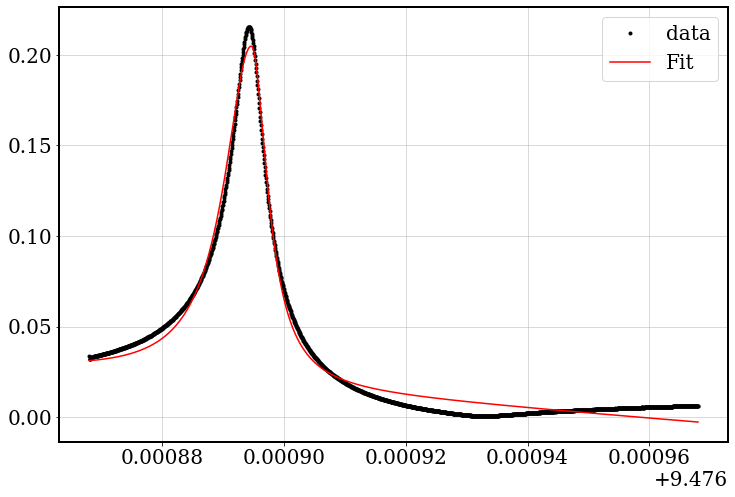

In [ ]:
fit_resonance(freq*1e-6, power)

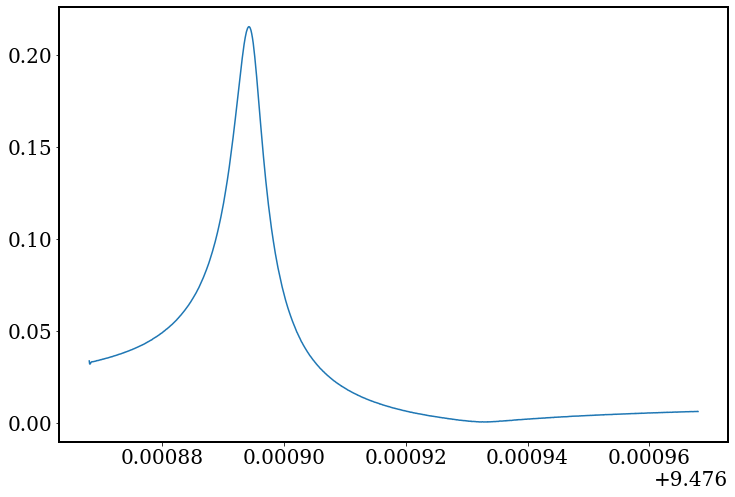

In [ ]:
plt.plot(freq*1e-6, linmag)
plt.show()

In [ ]:
from lmfit.models import BreitWignerModel, QuadraticModel, LinearModel, SplineModel, Model

mod = BreitWignerModel(prefix='res_')
#pars = mod.guess(linmag, x=freq)
pars = mod.make_params()
pars["res_sigma"].set(value=32)
pars["res_amplitude"].set(value=0.01)
pars["res_q"].set(value=-1.2)
pars["res_center"].set(value= float(freq[np.where(np.max(linmag))] + 90))

#knot_xvals = np.linspace(np.min(freq),np.max(freq),10)
#bkg = SplineModel(prefix='baseline_', xknots=knot_xvals)
#pars.update(bkg.guess(linmag, freq))
##pars["slope"].set(value=-10)
##pars["intercept"].set(value=0)


bkg = LinearModel(prefix='baseline_')
pars.update(bkg.guess(linmag, freq))
pars["baseline_slope"].set(value=-1)
#pars["intercept"].set(value=0)


modsum = mod + bkg

#x=np.linspace(np.min(freq)-1000,np.max(freq),2000)
#out = mod.eval(pars, x=freq)

out = modsum.fit(linmag, pars, x=freq)
print(out.fit_report(min_correl=0.3))


[[Model]]
    (Model(breit_wigner, prefix='res_') + Model(linear, prefix='baseline_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 391
    # data points      = 1601
    # variables        = 6
    chi-square         = 2.40744420
    reduced chi-square = 0.00150937
    Akaike info crit   = -10394.2087
    Bayesian info crit = -10361.9384
    R-squared          = 0.33531790
##  Warning: uncertainties could not be estimated:
[[Variables]]
    res_amplitude:      -1.22764005 +/-        nan (nan%) (init = 0.01)
    res_center:          9476703.93 +/-        nan (nan%) (init = 9476958)
    res_sigma:           99.9801753 +/- 10913.0572 (10915.22%) (init = 32)
    res_q:              -2.25696523 +/- 269.066020 (11921.58%) (init = -1.2)
    baseline_slope:      0.00177126 +/-        nan (nan%) (init = -1)
    baseline_intercept: -16785.7830 +/-        nan (nan%) (init = 9055.603)
[[Correlations]] (unreported correlations are < 0.300)
    C(res_sigma, res_q) = +1

/home/cmsdaq/Analysis/bawenv/lib/python3.8/site-packages/lmfit/parameter.py:519: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(covar[vindex, vindex])
/home/cmsdaq/Analysis/bawenv/lib/python3.8/site-packages/uncertainties/core.py:173: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


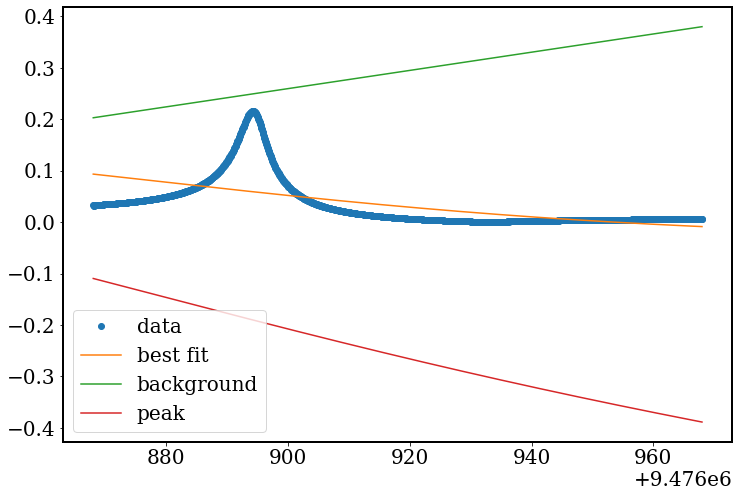

In [ ]:
comps = out.eval_components()

plt.plot(freq, linmag, 'o', label = 'data')
#plt.plot(x,out, '-', label='best fit')
plt.plot(freq, out.best_fit, '-', label='best fit')
plt.plot(freq, comps['baseline_'], label='background')
plt.plot(freq, comps['res_'], label='peak')

plt.legend()
plt.show()

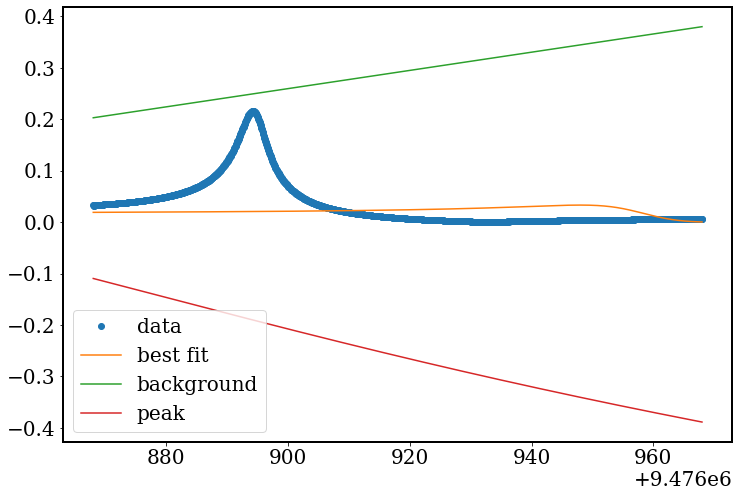

In [ ]:
pars["res_sigma"].set(value=22)
pars["res_amplitude"].set(value=0.015)
pars["res_q"].set(value=-1.1)
pars["res_center"].set(value= float(freq[np.where(np.max(linmag))] + 90))
out = mod.eval(pars, x=freq)

plt.plot(freq, linmag, 'o', label = 'data')
#plt.plot(x,out, '-', label='best fit')
plt.plot(freq, out, '-', label='best fit')
plt.plot(freq, comps['baseline_'], label='background')
plt.plot(freq, comps['res_'], label='peak')

plt.legend()
plt.show()

In [ ]:
def RLC(x, A, RB, LB, CB, CS, RL, RG):

    num = RL

    dennum = (CB**2 * CS * RB**2 * x**2 + (1 - CB * LB * x**2) * (CB + CS - CB * CS * LB * x**2))**2 + x**2 * (CB**2 * RB  + RG * (CB**2 * CS**2 * RB**2 * x**2 + (CB + CS - CB * CS * LB * x**2)**2) + RL * (CB**2 * CS**2 * RB**2 * x**2 + (CB + CS - CB * CS * LB * x**2)**2))**2
    denden = x**2 * (CB**2 * CS**2 * RB**2 * x**2 + (CB + CS - CB * CS * LB * x**2)**2)**2

    den = np.sqrt(dennum / denden)

    return A * num / den


def set_parameter(minuit_obj=None,name=None,p0=None,pmin=None,pmax=None,step=None,fixed=False):
    m1.values[name] = p0
    m1.limits[name]=(pmin,pmax)
    if step is not None:
        m1.errors[name]=step
    m1.fixed[name]=fixed
    return 

A:  1
RB:  30
LB:  3.290448
CB:  8.571428571428571e-17
CS:  9.92e-12
RL:  30
RG:  30
[[Model]]
    Model(RLC)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 1601
    # variables        = 5
    chi-square         = 3.62195739
    reduced chi-square = 0.00226940
    Akaike info crit   = -9742.28196
    Bayesian info crit = -9715.39004
    R-squared          = -2.5112e-06
##  Warning: uncertainties could not be estimated:
    RB:  at initial value
    RB:  at boundary
    CS:  at initial value
    CS:  at boundary
[[Variables]]
    A:   1 (fixed)
    RB:  30.0000000 (init = 30)
    LB:  3.29576040 (init = 3.290448)
    CB:  0.81409333 (init = 8.571429e-17)
    CS:  1.8389e-11 (init = 9.92e-12)
    RL:  30.8425546 (init = 30)
    RG:  30 (fixed)


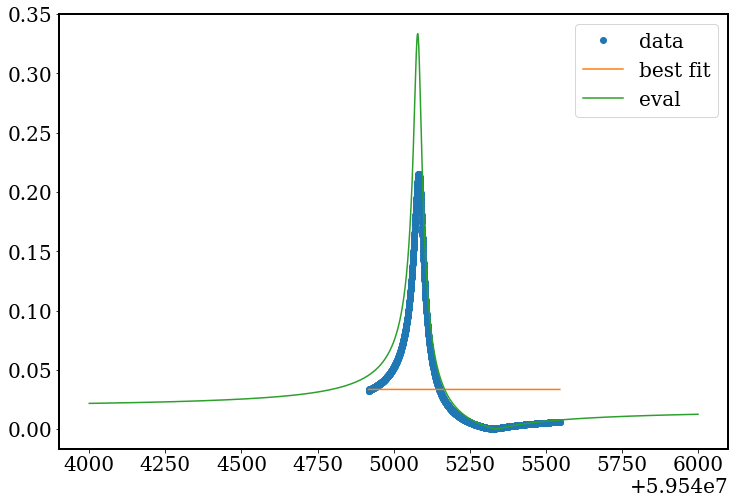

In [ ]:
modRLC = Model(RLC)
parsRLC = modRLC.make_params(A = dict(value=1, vary=False),
                             RB = dict(value=30, min=30, max=60, vary=True),
                             LB = dict(value=0.940128*3.5, min=0, vary=True),
                             CB = dict(value=0.3e-15/3.5, min=0, vary=True),
                             CS = dict(value=2.48e-12*4, min=0, vary=True),
                             RL = dict(value=18, min=30, max=70, vary=True),
                             RG = dict(value=0, min=30, max=70, vary=False))

for par,val in parsRLC.items():
    print(par+": ",val.value)


x = freq*2*np.pi
xx = np.linspace(5.9544e7,5.9546e7,10000)

outEval = modRLC.eval(parsRLC, x=xx)
outFit = modRLC.fit(linmag, parsRLC, x=x, method='leastsq', max_nfev=1000000)

print(outFit.fit_report(min_correl=0.3))


plt.plot(x, linmag, 'o', label = 'data')
plt.plot(x, outFit.best_fit, '-', label='best fit')
plt.plot(xx, outEval, '-', label='eval')

plt.legend()
plt.show()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 401 (χ²/ndof = 0.3)        │             Nfcn = 1069              │
│ EDM = 9.46e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │    1.0    │    0.1    │            │            │    0    │   10    │  yes  │
│ 1 │ RB   │   84.59   │   0.12    │            │            │   10    │   90    │       │
│ 2 │ LB   │3.5724872402│0.0000000024│            │            │    0    │    5    │       │
│ 3 │ CB   │78.9473408e-18│0.0000020e-18│            │            │    0    │  3e-13  │       │
│ 4 │ CS   │ 9.862e-12 │ 0.024e-12 │            │            │    0    │  2e-11  │       │
│ 5 │ RL   │  23.231   │   0.018   │            │            │   10    │   80    │       │
│ 6 │ RG   │    0.0    │    0.1    │            │            │   -1    │   80    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                           A                          RB                          LB                          CB                          CS                          RL                          RG │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  A │                           0                       0.000                       0e-18                       0e-48                           0                           0                           0 │
│ RB │                       0.000                      0.0148               30.282079e-12 7.335751022380155639269e-27         -466.7098878211e-18                     1.78e-3                       0.000 │
│ LB │                       0e-18               30.282079e-12                    5.62e-18       -657.325364839494e-36                -23.4013e-24                4.364365e-12                       0e-18 │
│ CB │                       0e-48 7.335751022380155639269e-27       -657.325364839494e-36                    3.87e-48            22.041971643e-39 1.266264616367198669877e-27                       0e-48 │
│ CS │                           0         -466.7098878211e-18                -23.4013e-24            22.041971643e-39                    5.93e-28          -91.6241721603e-18                           0 │
│ RL │                           0                     1.78e-3                4.364365e-12 1.266264616367198669877e-27          -91.6241721603e-18                    0.000341                           0 │
│ RG │                           0                       0.000                       0e-18                       0e-48                           0                           0                           0 │
└────┴────────────────────────

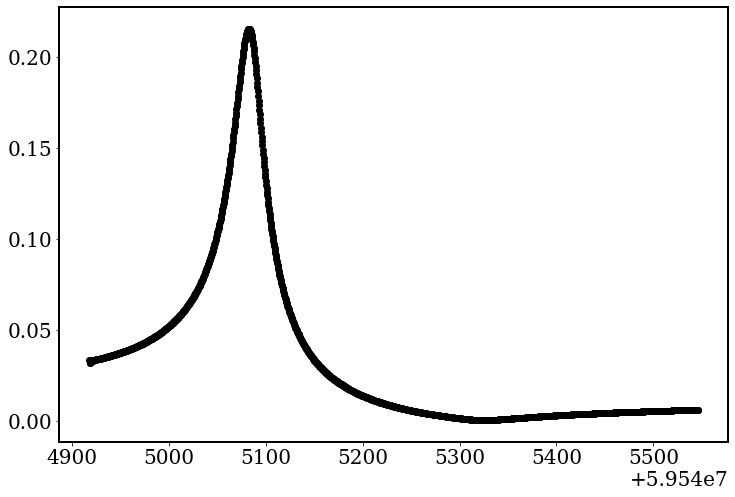

In [ ]:
import iminuit
from iminuit import cost, Minuit
#Minuit.print_level = 2
Minuit.strategy = 2

c = cost.LeastSquares(x, linmag, np.ones(len(linmag))*1e-3, RLC, verbose=0)

m1 = Minuit(c, A=0, RB=0, LB=0, CB=0, CS=0, RL=0, RG=0)

A_guess = 1
RB_guess = 30
#LB_guess = 3.1614  #freddo
#LB_guess = 3.1526  #caldo
#LB_guess = 0.94011  #caldo low freq
CB_guess = 0.3e-15/3.8
LB_guess = 0.940128*3.8 #1. / (CB_guess * x[np.where(np.max(linmag))[0]]**2)
CS_guess = 2.48e-12*4
RL_guess = 18
RG_guess = 0

#A_guess = 1
#RB_guess = 50
#CB_guess = 0.3e-15/3.5
#LB_guess = 0.940128*3.5
#CS_guess = 2.48e-12*4
#RL_guess = 50
#RG_guess = 50


set_parameter(m1,'A',  p0=A_guess, pmin=0 ,pmax=10 , fixed=True)
set_parameter(m1,'RB', p0=RB_guess, pmin=10 ,pmax=90 , fixed=False)
set_parameter(m1,'LB', p0=LB_guess, pmin=0 ,pmax=5 , fixed=False)
set_parameter(m1,'CB', p0=CB_guess, pmin=0 ,pmax=3e-13 , fixed=False)
set_parameter(m1,'CS', p0=CS_guess, pmin=0 ,pmax=20e-12 , fixed=False)
set_parameter(m1,'RL', p0=RL_guess, pmin=10 ,pmax=80 , fixed=False)
set_parameter(m1,'RG', p0=RG_guess, pmin=-1 ,pmax=80 , fixed=True)

#set_parameter(m1,'A',  p0=A_guess, pmin=0 ,pmax=10 , fixed=True)
#set_parameter(m1,'RB', p0=RB_guess, pmin=7 ,pmax=60 , fixed=False)
#set_parameter(m1,'LB', p0=LB_guess, pmin=0 ,pmax=10 , fixed=False)
#set_parameter(m1,'CB', p0=CB_guess, pmin=0 ,pmax=3e-14 , fixed=False)
#set_parameter(m1,'CS', p0=CS_guess, pmin=0 ,pmax=6e-12 , fixed=False)
#set_parameter(m1,'RL', p0=RL_guess, pmin=10 ,pmax=70 , fixed=False)
#set_parameter(m1,'RG', p0=RG_guess, pmin=7 ,pmax=60 , fixed=False)

m1.migrad(iterate=100, ncall=1000000)


In [ ]:
#m1.draw_mnmatrix()

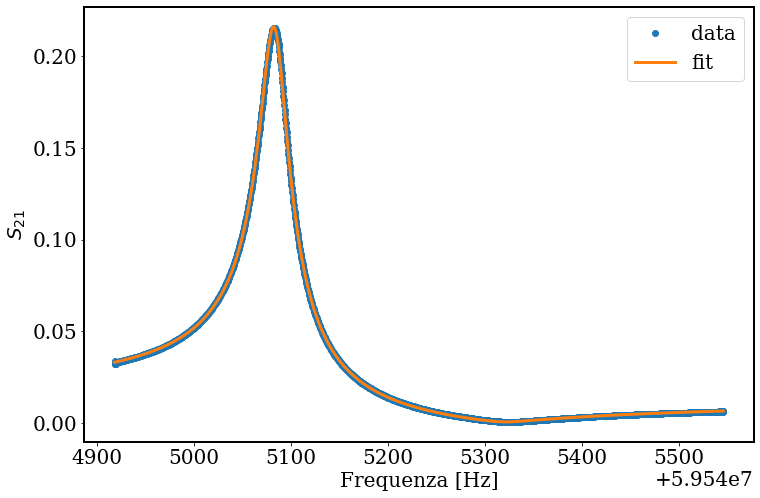

In [ ]:
plt.plot(x, linmag, 'o', label='data')
plt.plot(x, RLC(x, *m1.values), '-', label='fit', linewidth = 3)
plt.xlabel('Frequenza [Hz]')
plt.ylabel('$S_{21}$')
plt.legend()
plt.show()


In [ ]:
#Q = 2*gamma / omega = 1/R * sqrt(L/C)
#gamma = R/2L
#omega = 1/sqrt(LC)